# Setup and data

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [79]:
TRAIN_PATIENTS = ['100', '101', '102']
TEST_PATIENTS = ['106', '119']

In [80]:
SAMPLES_BEFORE = 30
SAMPLES_AFTER = 60
WINDOW_SIZE = SAMPLES_BEFORE + SAMPLES_AFTER

In [81]:
# Cechy PCA - tyle kubitów
N_DIM = 8
LIMIT_PER_PATIENT = 600

In [82]:
NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']
ANOMALY_SYMBOLS = ['V', 'A', 'a', 'J', 'S', 'F', '!', 'E', '/']

In [83]:
def load_patient_data(patiend_id):
    # Wczytuje sygnał i wycina uderzenia na podstawie adnotacji
    ekg_file = f'archive/{patiend_id}_ekg.csv'
    ann_file = f'archive/{patiend_id}_annotations_1.csv'
    
    if not os.path.exists(ekg_file) or not os.path.exists(ann_file):
        print('nie ma pliku')
        return [], []
    
    # wczytywanie sygnału ekg dla pacjenta, szukam po tej kolumnie MLII
    df_ekg = pd.read_csv(ekg_file)
    # Usuwamy spacje z nazw kolumn (częsty błąd w CSV)
    df_ekg.columns = df_ekg.columns.str.strip()
    
    try:
        if 'MLII' in df_ekg.columns:
                signal = df_ekg['MLII'].values
        elif 'V5' in df_ekg.columns:
            signal = df_ekg['V5'].values
        else:
            # Jeśli nie ma nazw, bierzemy kolumnę indeks 1 (bo 0 to zazwyczaj czas/sample)
            signal = df_ekg.iloc[:, 1].values
    except Exception as e:
        print(f'error {e}')
        return [], []
    
    signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    
    try:
        df_ann = pd.read_csv(ann_file)
        df_ann.columns = df_ann.columns.str.strip() # Czyścimy nazwy
            
        # Szukamy odpowiednich kolumn (sample = pozycja, symbol = typ)
        # Czasami nazywają się 'sample', 'Sample', 'time', etc.
        sample_col = next((c for c in df_ann.columns if 'index' in c.lower()), None)
        symbol_col = next((c for c in df_ann.columns if 'annotation_symbol' in c.lower()), None)
        
        if not sample_col or not symbol_col:
            print("  Nie znaleziono kolumn 'sample' lub 'symbol' w adnotacjach.")
            return [], []
        
        peaks = df_ann[sample_col].values
        symbols = df_ann[symbol_col].values
    except Exception as e:
        print(f'blad {e}')
        return [], []
    
    beats_normal = []
    beats_anomaly = []
    
    for p, sym in zip(peaks, symbols):
        # Pomijamy uderzenia na samym początku lub końcu nagrania
        if p - SAMPLES_BEFORE < 0 or p + SAMPLES_AFTER > len(signal):
            continue
            
        # Wycinek
        window = signal[p - SAMPLES_BEFORE : p + SAMPLES_AFTER]
        
        # Upewniamy się, że długość jest idealna
        if len(window) != WINDOW_SIZE:
            continue

        # Klasyfikacja
        if sym in NORMAL_SYMBOLS:
            if len(beats_normal) < LIMIT_PER_PATIENT:
                beats_normal.append(window)
        elif sym in ANOMALY_SYMBOLS:
            if len(beats_anomaly) < LIMIT_PER_PATIENT:
                beats_anomaly.append(window)
                
    print(f"  -> Znaleziono: {len(beats_normal)} Normal, {len(beats_anomaly)} Anomaly")
    return beats_normal, beats_anomaly

>>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...
  -> Znaleziono: 600 Normal, 34 Anomaly
  -> Znaleziono: 600 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 600 Anomaly

>>> KROK 2: Wczytywanie danych testowych (Mieszane)...
  -> Znaleziono: 600 Normal, 520 Anomaly
  -> Znaleziono: 600 Normal, 444 Anomaly

STATUS DANYCH SUROWYCH:
Wymiar pojedynczego uderzenia: 90 próbek
Liczba próbek Train (Normal): 1299
Liczba próbek Test (Anomaly): 964

>>> KROK 3: Redukcja wymiaru (PCA) z 90 do 8...
Wyjaśniona wariancja (ile info zachowaliśmy): 99.48%
>>> KROK 4: Skalowanie do zakresu (0, pi)...

>>> KROK 5: Zapisywanie plików .npy...
GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.

>>> Generowanie wykresu kontrolnego...


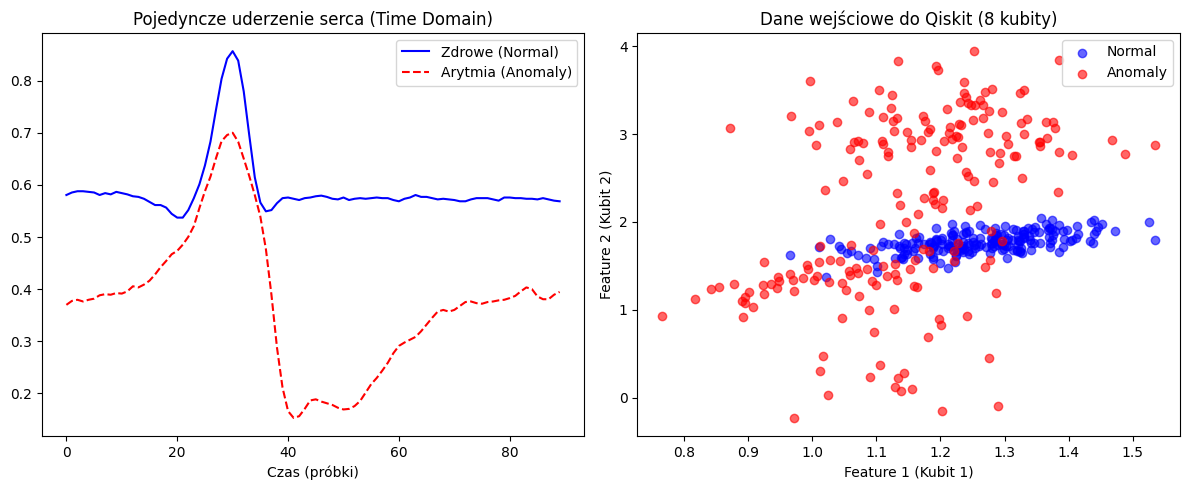

In [84]:
def main():
    # --- ZBIERANIE DANYCH ---
    all_train_normal = []
    all_test_normal = []
    all_test_anomaly = []

    print(">>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...")
    for pid in TRAIN_PATIENTS:
        n, _ = load_patient_data(pid)
        all_train_normal.extend(n)

    print("\n>>> KROK 2: Wczytywanie danych testowych (Mieszane)...")
    for pid in TEST_PATIENTS:
        n, a = load_patient_data(pid)
        all_test_normal.extend(n)
        all_test_anomaly.extend(a)

    # Konwersja na numpy array
    X_train = np.array(all_train_normal)
    X_test_normal = np.array(all_test_normal)
    X_test_anomaly = np.array(all_test_anomaly)

    print(f"\nSTATUS DANYCH SUROWYCH:")
    print(f"Wymiar pojedynczego uderzenia: {WINDOW_SIZE} próbek")
    print(f"Liczba próbek Train (Normal): {X_train.shape[0]}")
    print(f"Liczba próbek Test (Anomaly): {X_test_anomaly.shape[0]}")

    if len(X_train) == 0:
        print("BŁĄD KRYTYCZNY: Brak danych treningowych. Sprawdź nazwy plików CSV!")
        return

    # --- PRZETWARZANIE (PCA) ---
    print(f"\n>>> KROK 3: Redukcja wymiaru (PCA) z {WINDOW_SIZE} do {N_DIM}...")
    
    # 1. Trenujemy PCA tylko na zdrowych danych treningowych
    pca = PCA(n_components=N_DIM)
    pca.fit(X_train)
    
    # 2. Transformujemy wszystkie zbiory
    X_train_pca = pca.transform(X_train)
    X_test_normal_pca = pca.transform(X_test_normal)
    
    # Obsługa przypadku, gdyby nie było anomalii (żeby kod nie padł)
    if len(X_test_anomaly) > 0:
        X_test_anomaly_pca = pca.transform(X_test_anomaly)
    else:
        X_test_anomaly_pca = np.empty((0, N_DIM))

    print(f"Wyjaśniona wariancja (ile info zachowaliśmy): {sum(pca.explained_variance_ratio_):.2%}")

    # --- SKALOWANIE DO KOMPUTERA KWANTOWEGO ---
    # Qiskit lubi dane w zakresie (0, pi) lub (-1, 1). 
    # Użyjemy (0, pi) pod bramki rotacji.
    print(">>> KROK 4: Skalowanie do zakresu (0, pi)...")
    
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    scaler.fit(X_train_pca) # Uczymy skaler na treningu
    
    X_train_final = scaler.transform(X_train_pca)
    X_test_normal_final = scaler.transform(X_test_normal_pca)
    
    if len(X_test_anomaly) > 0:
        X_test_anomaly_final = scaler.transform(X_test_anomaly_pca)
    else:
        X_test_anomaly_final = X_test_anomaly_pca

    # --- ZAPISYWANIE ---
    print("\n>>> KROK 5: Zapisywanie plików .npy...")
    np.save('train_data.npy', X_train_final)
    np.save('test_normal.npy', X_test_normal_final)
    np.save('test_anomaly.npy', X_test_anomaly_final)
    print("GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.")

    # --- WIZUALIZACJA ---
    print("\n>>> Generowanie wykresu kontrolnego...")
    plt.figure(figsize=(12, 5))
    
    # Wykres 1: Jak wygląda surowe uderzenie?
    plt.subplot(1, 2, 1)
    plt.plot(X_train[0], label='Zdrowe (Normal)', color='blue')
    if len(X_test_anomaly) > 0:
        plt.plot(X_test_anomaly[0], label='Arytmia (Anomaly)', color='red', linestyle='--')
    plt.title("Pojedyncze uderzenie serca (Time Domain)")
    plt.xlabel("Czas (próbki)")
    plt.legend()
    
    # Wykres 2: Jak to wygląda po PCA?
    plt.subplot(1, 2, 2)
    # Rysujemy tylko po 100 kropek żeby było czytelnie
    plt.scatter(X_test_normal_final[:200, 0], X_test_normal_final[:200, 1], 
                c='blue', alpha=0.6, label='Normal')
    if len(X_test_anomaly_final) > 0:
        plt.scatter(X_test_anomaly_final[:200, 0], X_test_anomaly_final[:200, 1], 
                    c='red', alpha=0.6, label='Anomaly')
    plt.title(f"Dane wejściowe do Qiskit ({N_DIM} kubity)")
    plt.xlabel("Feature 1 (Kubit 1)")
    plt.ylabel("Feature 2 (Kubit 2)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

C:\Users\Marcepano\AppData\Local\Temp\ipykernel_4760\3194141157.py:43: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Marcepano\AppData\Local\Temp\ipykernel_4760\3194141157.py:45: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


>>> 1. Wczytywanie danych (8 cech)...
    Trening na: 1299 próbkach
>>> 2. Budowanie obwodu (8 kubitów)...
>>> 3. Start treningu (Optimizer: SPSA, Iter: 60)...
    Iter 5: Koszt = 0.4326
    Iter 10: Koszt = 0.5138
    Iter 15: Koszt = 0.5549
    Iter 20: Koszt = 0.3930
    Iter 25: Koszt = 0.4442
    Iter 30: Koszt = 0.5535
    Iter 35: Koszt = 0.5797
    Iter 40: Koszt = 0.3859
    Iter 45: Koszt = 0.4304
    Iter 50: Koszt = 0.5547
    Iter 55: Koszt = 0.1900
    Iter 60: Koszt = 0.2651
    Iter 65: Koszt = 0.0898
    Iter 70: Koszt = 0.0515
    Iter 75: Koszt = 0.0896
    Iter 80: Koszt = 0.0807
    Iter 85: Koszt = 0.0659
    Iter 90: Koszt = 0.0692
    Iter 95: Koszt = 0.0551
    Iter 100: Koszt = 0.1019
    Iter 105: Koszt = 0.0950
    Iter 110: Koszt = 0.0879
    Iter 115: Koszt = 0.0807
    Iter 120: Koszt = 0.0562
    Iter 125: Koszt = 0.0641
    Iter 130: Koszt = 0.0812
    Iter 135: Koszt = 0.0654
    Iter 140: Koszt = 0.0424
    Iter 145: Koszt = 0.0552
    Iter 150: Koszt

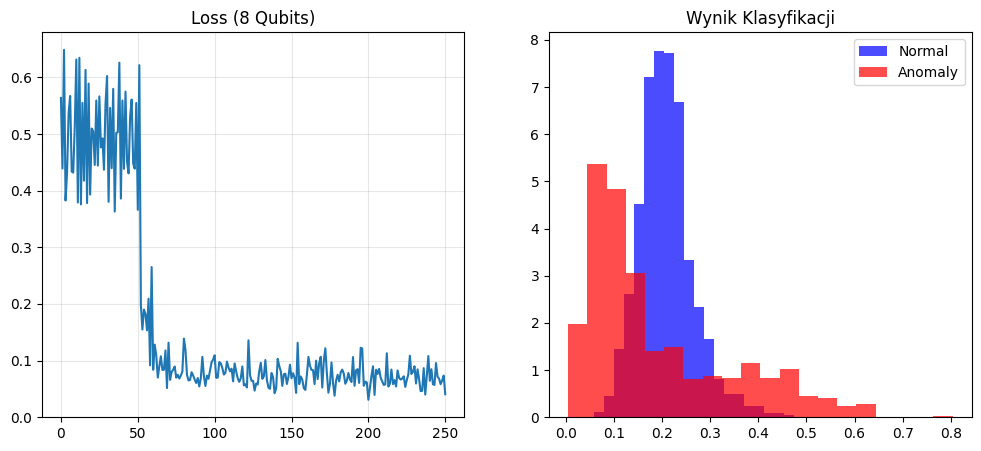

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA
from qiskit_machine_learning.neural_networks import SamplerQNN

# IBM Cloud Imports (To musisz doinstalować: pip install qiskit-ibm-runtime)
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options

# --- KONFIGURACJA ---
USE_REAL_HARDWARE = False  # <--- Zmień na True, jak będziesz gotowy na IBM
IBM_TOKEN = "TU_WKLEJ_SWOJ_TOKEN_Z_IBM_QUANTUM" 

INPUT_DIM = 8     # Teraz mamy 8 cech
LATENT_DIM = 4    # Kompresujemy do 4 kubitów
MAX_ITER = 60     # Dajmy mu trochę czasu
BATCH_SIZE = 25 

def main():
    print(f">>> 1. Wczytywanie danych (8 cech)...")
    try:
        train_data = np.load('train_data.npy')
        test_normal = np.load('test_normal.npy')
        test_anomaly = np.load('test_anomaly.npy')
    except:
        print("BŁĄD: Nie znaleziono plików. Uruchom najpierw prepare_data.py z N_DIM=8!")
        return

    # Sprawdzenie czy wymiary pasują
    if train_data.shape[1] != INPUT_DIM:
        print(f"BŁĄD: Dane mają wymiar {train_data.shape[1]}, a kod oczekuje {INPUT_DIM}.")
        return

    print(f"    Trening na: {len(train_data)} próbkach")

    # --- OBWÓD KWANTOWY ---
    print(">>> 2. Budowanie obwodu (8 kubitów)...")
    # ZFeatureMap jest OK, ale ZZFeatureMap bywa lepsza (choć wolniejsza). Zostańmy przy Z.
    feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
    # reps=2 da lepszą ekspresję niż reps=1
    ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
    
    qc = QuantumCircuit(INPUT_DIM)
    qc.append(feature_map, range(INPUT_DIM))
    qc.append(ansatz, range(INPUT_DIM))

    # --- WYBÓR BACKENDU (Symulator vs Prawdziwy) ---
    if USE_REAL_HARDWARE:
        print(">>> ŁĄCZENIE Z IBM QUANTUM...")
        # Zapisz konto (robisz to tylko raz)
        # QiskitRuntimeService.save_account(channel="ibm_quantum", token=IBM_TOKEN, overwrite=True)
        service = QiskitRuntimeService(channel="ibm_quantum")
        
        # Wybór najmniej obciążonego komputera
        backend = service.least_busy(operational=True, simulator=False)
        print(f"    Wybrano komputer: {backend.name}")
        # Tutaj konfiguracja Samplera dla IBM jest trudniejsza w pętli treningowej.
        # UWAGA: Trenowanie na prawdziwym sprzęcie zje Ci cały limit w 5 minut.
        # ZALECENIE: Trenuj na symulatorze, a na IBM puść tylko WALIDACJĘ (ostatni krok).
        print("!!! OSTRZEŻENIE: Trening na QPU jest bardzo wolny i kosztowny.")
        print("!!! Przełączam na lokalny symulator do treningu.")
    
    # Do treningu ZAWSZE używamy symulatora (chyba że masz budżet szejka naftowego)
    
    def parity(x):
        return x % 2

    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        interpret=parity,
        output_shape=2
    )

    # --- TRENING ---
    objective_func_vals = []
    
    def cost_func(params_values):
        batch_idx = np.random.choice(len(train_data), BATCH_SIZE, replace=False)
        batch_data = train_data[batch_idx]
        probs = qnn.forward(batch_data, params_values)
        cost = np.sum(probs[:, 1]) / BATCH_SIZE
        objective_func_vals.append(cost)
        if len(objective_func_vals) % 5 == 0:
            print(f"    Iter {len(objective_func_vals)}: Koszt = {cost:.4f}")
        return cost

    print(f">>> 3. Start treningu (Optimizer: SPSA, Iter: {MAX_ITER})...")
    
    # --- ZMIANA TUTAJ ---
    # COBYLA wyrzucamy:
    # optimizer = COBYLA(maxiter=MAX_ITER) 
    
    # Wstawiamy ADAM. 
    # lr=0.01 to "learning rate". Jak wykres skacze jak szalony, zmniejsz do 0.001.
    #optimizer = ADAM(maxiter=MAX_ITER, lr=0.01) 
    optimizer = SPSA(maxiter=100)
    
    initial_weights = 0.1 * (2 * np.random.random(ansatz.num_parameters) - 1)

    start_t = time.time()
    # ADAM wymaga gradientów, ale Qiskit SamplerQNN policzy je sobie sam (metodą różnic skończonych)
    result = optimizer.minimize(fun=cost_func, x0=initial_weights)
    print(f">>> Czas treningu: {time.time() - start_t:.1f} s")

    # --- WYNIKI ---
    print(">>> 4. Generowanie wyników...")
    trained_weights = result.x
    
    # Funkcja do ewaluacji (z batchem)
    def get_scores(data):
        scores = []
        for i in range(0, len(data), 50): # Mniejsze paczki dla 8 kubitów
            batch = data[i:i+50]
            p = qnn.forward(batch, trained_weights)
            scores.extend(p[:, 1])
        return scores

    s_norm = get_scores(test_normal)
    s_anom = get_scores(test_anomaly)

    # --- WIZUALIZACJA ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(objective_func_vals)
    plt.title("Loss (8 Qubits)")
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(s_norm, bins=20, alpha=0.7, color='blue', label='Normal', density=True)
    plt.hist(s_anom, bins=20, alpha=0.7, color='red', label='Anomaly', density=True)
    plt.title("Wynik Klasyfikacji")
    plt.legend()
    plt.savefig("results_8qubits.png")
    plt.show()

if __name__ == "__main__":
    main()